# Importing all needed Libraries :

In [1]:
import sys
import os
import numpy as np
import requests
import config
from urllib import request
from sklearn import tree
import pandas as pd
import pydotplus
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
import time

# Importing Data from OP.GG into OP.GG.txt :

In [2]:
def GatherData(Username):
    Temp=open("OP.GG.txt",'w+')
    Link=("https://euw.op.gg/summoner/userName=%s"%Username)
    File = request.urlopen(Link)
    Data = File.readlines()
    Temp.write(str(Data))
    Temp.close()

# Gathering individuals winrate from Team :

In [3]:
def Winrate():
    #---------------------------------------------------------------------------------------
    #Declarations :
    Elos={'Elo':["IRON","BRONZE","SILVER","GOLD","PLATINUM","DIAMOND","MASTER","GRANDMASTER","CHALLENGER"]}
    Verif=False
    Ranked=False
    Temp=open("OP.GG.txt",'r')
    Data=Temp.read().split(",")
    Temp.close()
    #---------------------------------------------------------------------------------------
    for Line in Data:
        for i in range (0,8):
            if str(Elos['Elo'][i]) in str(Line.upper()):
                Verif=True
                break;
            else:
                Verif=False
        if 'Win Ratio' in Line and '%' in Line and Verif==True:
            Ranked=True
            break;
    if Ranked==True:
        L=Line.split(" ")
        L=list(str(L[len(L)-1]))
        Ratio=int(str(f"{L[0]}{L[1]}"))
        return Ratio;
    else:
        return 0;

# Appending each Laner his according Data :

In [4]:
def TeamData():
    S=[]
    Laners={"Laner":["Toplaner","Jungler","Midlaner","ADC","Support"]}
    for i in range(0,5):
        Username=input(f"Enter the {Laners['Laner'][i]}'s Summoner's name :\n")
        GatherData(Username)
        S.append(Winrate())
    return S;

# Convert map side input to binary values :

In [5]:
def Conv(Side):
    if Side.upper()=="RED" or Side.upper()=="RED TEAM":
        B=int(0)
        R=int(1)
        return B,R;
    elif Side.upper()=="BLUE" or Side.upper()=="BLUE TEAM":
        B=int(1)
        R=int(0)
        return B,R;
    else:
        return print("Invalid answer.");

# Fetching Data from 100 Scanned Games :

In [6]:
def Importing():
    ADATA=pd.read_csv("LeagueoflegendsData.csv",encoding="ISO-8859-1")
    One_Hot_Data=pd.get_dummies(ADATA[['Team','Inters&AFK','Trollpicks']])
    return ADATA,One_Hot_Data;

# Visualizing our existing correlations manually :

In [7]:
def VisualizeDATA(ADATA,One_Hot_Data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x=ADATA['Inters&AFK'].astype(int)
    y=One_Hot_Data['Trollpicks'].astype(int)
    c=One_Hot_Data['Team_red'].astype(int)
    z=pd.get_dummies(ADATA['Output'])['win'].astype(int)
    ax.scatter(x, y, z, c=c, cmap=plt.cm.get_cmap('bwr'))
    ax.set_xlabel('Inters&AFK')
    plt.gca().invert_xaxis()
    ax.set_ylabel('Trollpicks')
    ax.set_zlabel('Winning')
    ax.set_title('Correlations :',c='purple')
    return plt.show

# Creating and Training our predictions model :

In [8]:
def DecisionTree(X,Y):
    CLF=tree.DecisionTreeClassifier()
    CLF_train=CLF.fit(Y,X['Output'])
    Dot_Data=tree.export_graphviz(CLF_train,out_file=None,feature_names=list(Y.columns.values),rounded=True,filled=True)
    return Dot_Data,CLF_train

# Visualizing our Decision Tree :

In [9]:
def VisualizeTree(Dot_Data):
    Graph=pydotplus.graph_from_dot_data(Dot_Data)
    return Image(Graph.create_png())

# Main Program :

Enter the Toplaner's Summoner's name :
Kzurro
Enter the Jungler's Summoner's name :
Zhao11
Enter the Midlaner's Summoner's name :
InvisibleFart
Enter the ADC's Summoner's name :
Him
Enter the Support's Summoner's name :
She
You are on the blue or red side of the map?
red
Underneath, You can find each of your team member's individual WinRatio :
[55, 50, 54, 75, 63]
How many players are declaring to go AFK or int since champ select?
2
How many trollpicks does your team have?
2
Your chance of winning is 44.4%


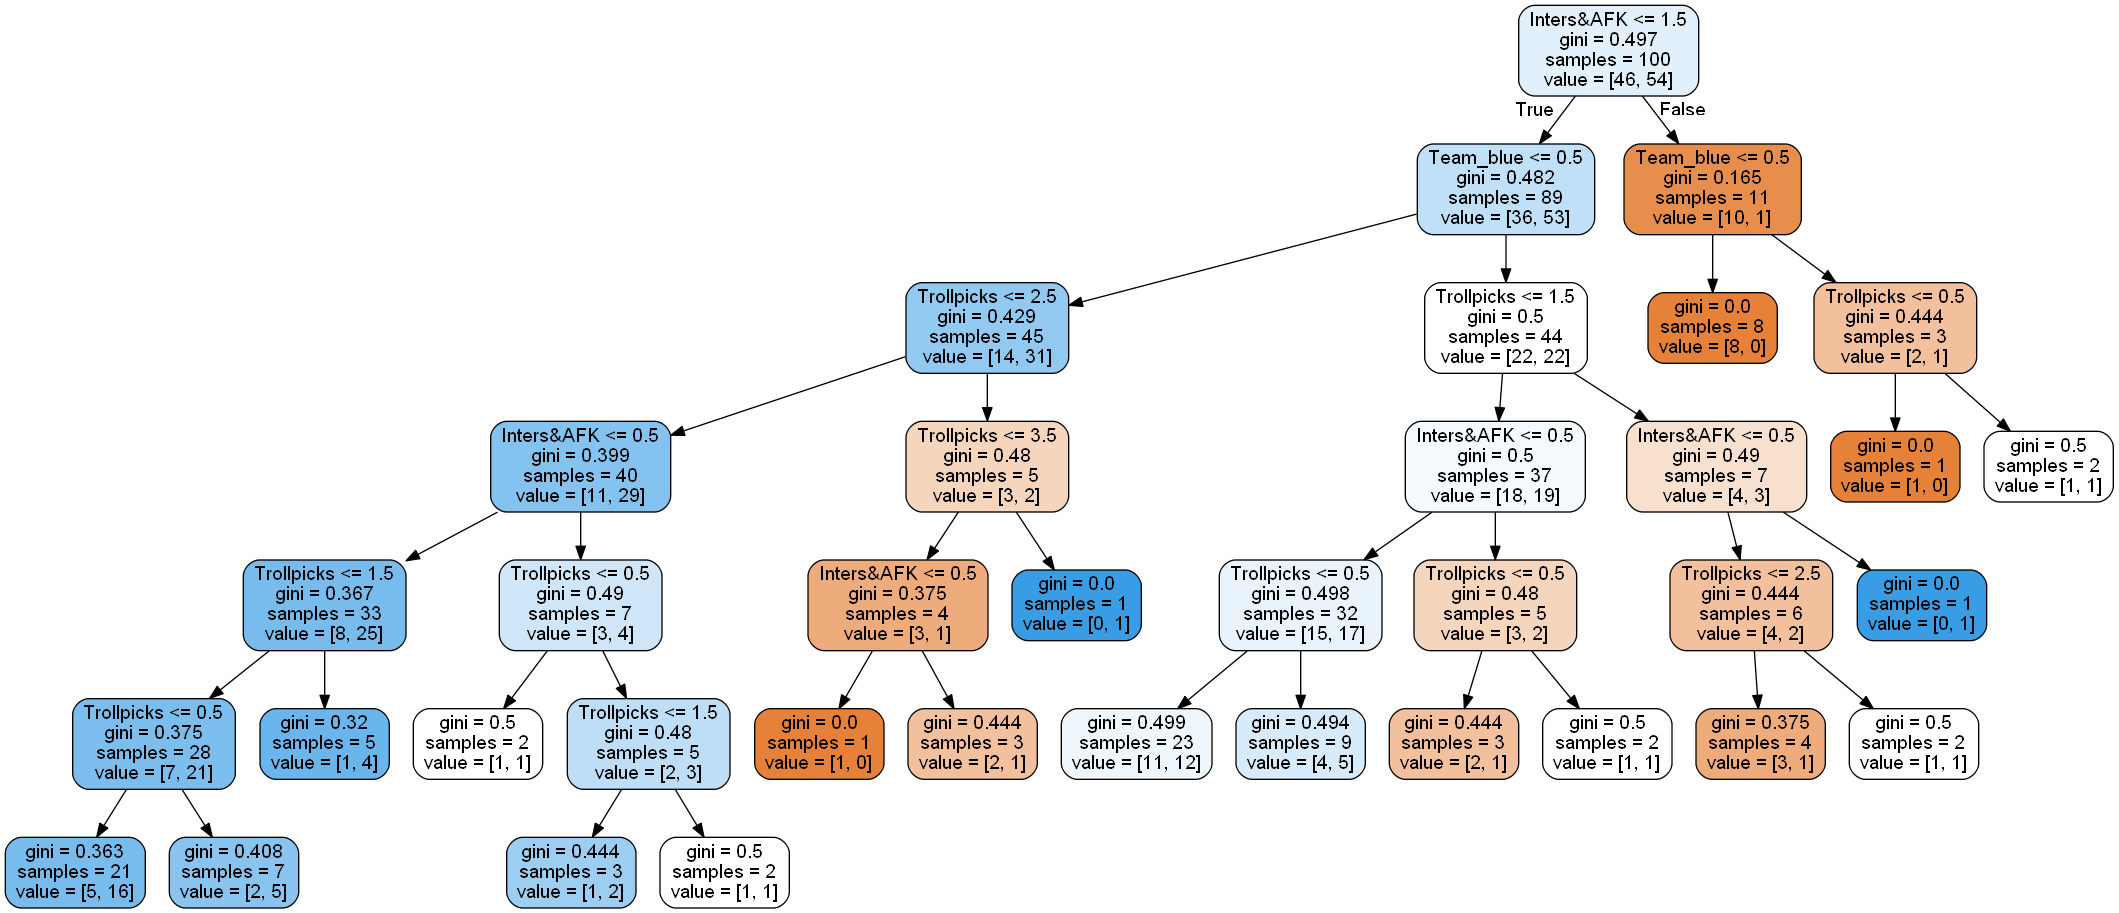

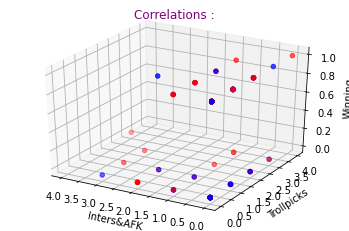

In [10]:
#Importing Data:
ADATA,One_Hot_Data=Importing()
Scores=TeamData()
Side=input("You are on the blue or red side of the map?\n")
B,R=Conv(Side)
print(f"Underneath, You can find each of your team member's individual WinRatio :\n{Scores}")
#Creating and training our Decision Tree model :
Dot_Data,CLF_train=DecisionTree(ADATA,One_Hot_Data)
#Making the prediction to wich we're adding accurate ratios from Forum :
Prediction=CLF_train.predict([[int(input("How many players are declaring to go AFK or int since champ select?\n")),int(input("How many trollpicks does your team have?\n")),B,R]])
Sum=0
for WinRatio in Scores:
    Sum+=WinRatio
if Prediction[0]=='lose':
    print(f"Your chance of winning is {(Sum/5)-15}%")
else:
    print(f"Your chance of winning is {(Sum/5)+15}%")
#Visualizations :
VisualizeDATA(ADATA,One_Hot_Data)
VisualizeTree(Dot_Data)